In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
UDACITY_DATA = './data/'
MY_DATA = './SimulationData/'

# data_path = UDACITY_DATA
data_path = MY_DATA

def get_image(data_folder, source_path):
    filename = source_path.split('/')[-1]
    current_path = data_folder + 'IMG/' + filename
    image = cv2.imread(current_path)
    # Convert to RGB as drive.py uses RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

images = []
steering_angles  = []
with open(data_path + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    # Skip headers in Udacity Data
    if data_path == UDACITY_DATA:
        next(reader)

    for line in reader:
        image_centre = get_image(data_path, line[0])
        image_left = get_image(data_path, line[1])
        image_right = get_image(data_path, line[2])

        angle_centre = float(line[3])
        correction = 0.1
        angle_left = angle_centre + correction
        angle_right = angle_centre - correction

        images.extend([image_centre, image_left, image_right])
        steering_angles.extend([angle_centre, angle_left, angle_right])    

In [3]:
# Data Augmentation
augmented_images = []
augmented_angles = []
for image, angle in zip(images, steering_angles):
    augmented_images.append(image)
    augmented_angles.append(angle)
    augmented_images.append(cv2.flip(image, 1))
    augmented_angles.append(angle * -1.0)

images = augmented_images
steering_angles = augmented_angles

In [4]:
X_train = np.array(images)
y_train = np.array(steering_angles)

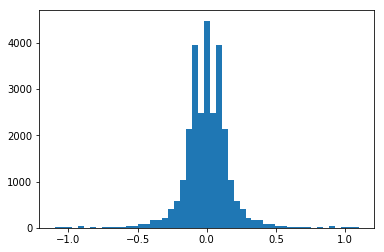

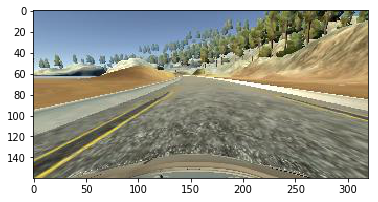

In [5]:
# Visualise the data

# Steering angle distribution
# the histogram of the data
n, bins, patches = plt.hist(y_train, 51)
plt.show()

# Image
# TODO - do this better with steering angle annotation + left/right/centre * flip (so 6 total per original frame)
test_img = X_train[0]
plt.imshow(test_img)

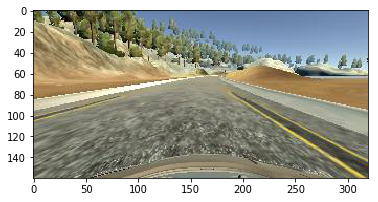

In [6]:
plt.imshow(X_train[1])

(160, 320, 3)
(110, 320, 3)


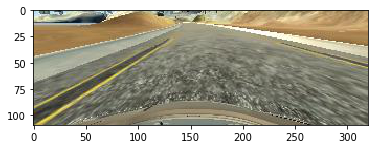

In [7]:
# Visualise the preprocessing
# (put the functions here and reference in the keras layers later)
def normalise(img):
    return img / 255.0 - 0.5

def crop(img, l=0, r=0, t=0, b=0):
    h, w, col = img.shape
    return img[t:h-b, l:w-r, :]

print(test_img.shape)
test_img = crop(test_img, t=50, b=0)
print(test_img.shape)
plt.imshow(test_img)

In [8]:
# MODEL = 'lenet'
MODEL = 'nvidia'

model = Sequential()

# Preprocessing layers
model.add(Cropping2D(cropping=((50,10), (0,0)), input_shape=(160, 320, 3)))
model.add(Lambda(normalise))
    
if MODEL == 'lenet':
    model.add(Convolution2D(6, 5, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
elif MODEL == 'nvidia':
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

In [9]:
# Training
checkpointer = ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss')
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2,
                    shuffle=True, nb_epoch=8, callbacks=[checkpointer])
model.save('model.h5')

Train on 22032 samples, validate on 5508 samples
Epoch 1/8
22032/22032 [==============================] - 59s - loss: 0.0217 - acc: 0.0754 - val_loss: 0.0070 - val_acc: 0.0058
Epoch 2/8
22032/22032 [==============================] - 58s - loss: 0.0153 - acc: 0.0761 - val_loss: 0.0054 - val_acc: 0.0058
Epoch 3/8
22032/22032 [==============================] - 58s - loss: 0.0112 - acc: 0.0765 - val_loss: 0.0037 - val_acc: 0.0058
Epoch 4/8
22032/22032 [==============================] - 58s - loss: 0.0082 - acc: 0.0768 - val_loss: 0.0039 - val_acc: 0.0058
Epoch 5/8
22032/22032 [==============================] - 58s - loss: 0.0060 - acc: 0.0770 - val_loss: 0.0033 - val_acc: 0.0058
Epoch 6/8
22032/22032 [==============================] - 58s - loss: 0.0046 - acc: 0.0774 - val_loss: 0.0034 - val_acc: 0.0058
Epoch 7/8
22032/22032 [==============================] - 58s - loss: 0.0037 - acc: 0.0774 - val_loss: 0.0035 - val_acc: 0.0058
Epoch 8/8
22032/22032 [==============================] - 58s -

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])


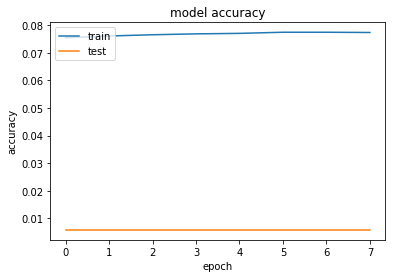

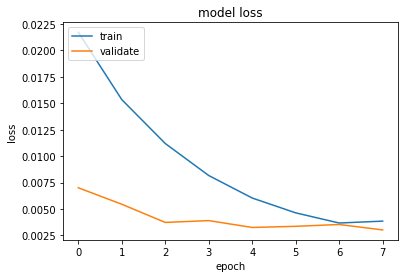

In [10]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()